In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загружаем данные по оценкам

date_parser = lambda x: pd.datetime.strptime(x, "%d.%m.%Y %H:%M:%S")
rating_data = pd.read_csv('kaggle_data_01.csv', parse_dates=[1], date_parser=date_parser)

In [3]:
rating_data.head()

,person_id,date,Id,Prediction1
0,person_9,2017-06-02 10:03:36,1,3.0
1,person_9,2017-06-09 08:34:08,2,3.0
2,person_9,2017-06-16 10:19:03,3,3.0
3,person_9,2017-06-23 12:08:57,4,3.0
4,person_9,2017-06-30 12:48:39,5,4.0


In [4]:
# разделяем на известные оценки и те, которые надо предсказать

rating_known = rating_data[~rating_data['Prediction1'].isna()]
rating_unknown = rating_data[rating_data['Prediction1'].isna()]

persons = rating_data['person_id'].unique()
persons_known = rating_known['person_id'].unique()
persons_unknown = rating_unknown['person_id'].unique()

In [5]:
# Загружаем данные по фичам

date_parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
action_data = pd.read_csv('kaggle_data_02.csv', header=None, parse_dates=[1], date_parser=date_parser)
feature_labels = [x for x in np.arange(action_data.shape[1]-2)]
header = ['person_id', 'date'] + feature_labels
action_data.columns = header

In [6]:
action_data.head()

,person_id,date,0,1,2,3,4,5,6,7,...,456,457,458,459,460,461,462,463,464,465
0,person_1,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,person_1,2017-06-02,29.0,12.0,37.0,32.0,128.0,16.0,2.0,15.0,...,16.0,0.0,57.0,15.0,16.0,3.0,0.0,21.0,7.0,10.0
2,person_1,2017-06-03,10.0,4.0,10.0,8.0,34.0,4.0,1.0,4.0,...,4.0,0.0,11.0,4.0,4.0,1.0,2.0,19.0,6.0,6.0
3,person_1,2017-06-04,3.0,3.0,3.0,6.0,40.0,3.0,1.0,3.0,...,3.0,0.0,6.0,3.0,3.0,0.0,1.0,16.0,4.0,4.0
4,person_1,2017-06-05,4.0,3.0,12.0,11.0,62.0,4.0,1.0,4.0,...,4.0,0.0,17.0,4.0,4.0,2.0,2.0,20.0,6.0,7.0


---
### Выборка за заданный интервал времени

In [1]:
# данные фич за заданный интервал времени

def get_range_data(df, start_date, end_date):
    mask = (df['date'] > start_date) & (df['date'] < end_date)
    return df[mask]

In [103]:
# данные фич по пользователю за заданный интервал времени

def get_range_data_by_person(data, person, start_date, end_date):
    df = data[data['person_id'] == person]
    mask = (df['date'] > start_date) & (df['date'] < end_date)
    return df[mask]

---
### Пропущенные значения

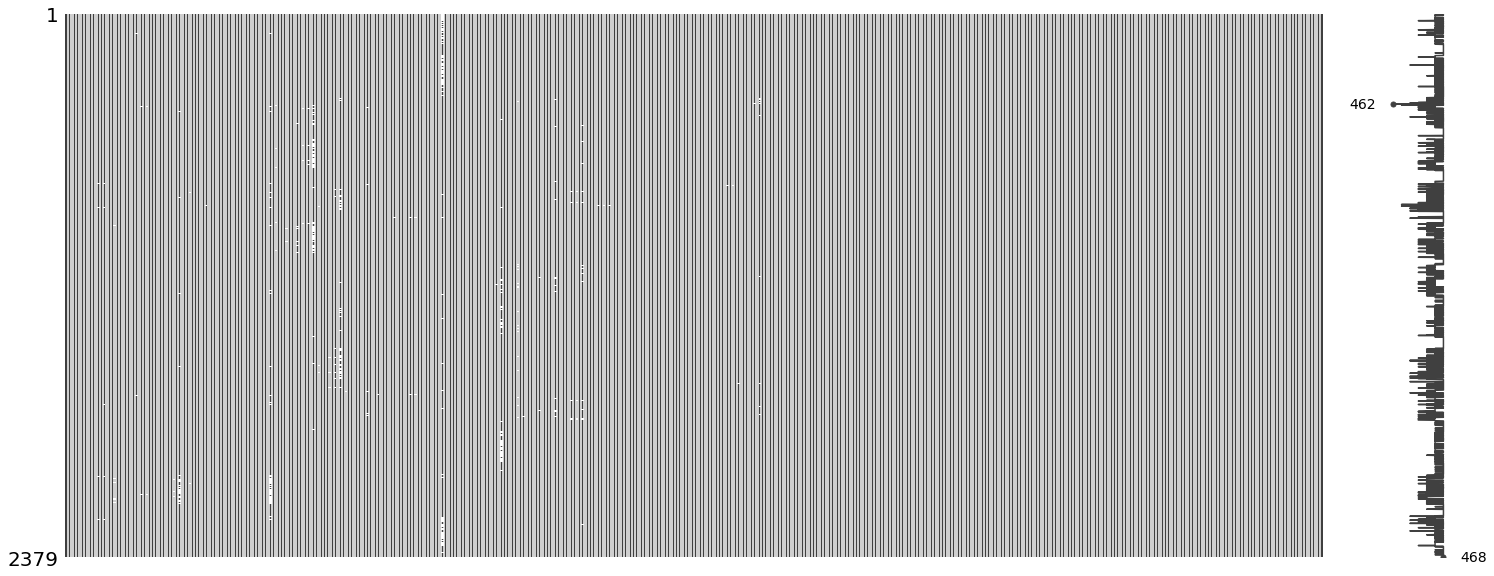

In [7]:
# Посмотрим в разрезе всех данных на пропуски

import missingno as msno

msno.matrix(action_data);

In [2]:
# Считаем пропущенные данные по столбцам

def missing_by_column(df, name):
    mis_val = df.isnull().sum().sort_values(ascending=False)
    mis_val = mis_val / df.shape[0] * 100
    mis_table = pd.DataFrame(round(mis_val, 1))
    mis_table = mis_table.rename(columns = {0 : name})
    mis_table = mis_table[mis_table[name] != 0]
    return mis_table.reset_index()

In [ ]:
def missing_by_range(df, name, start_date, end_date):
    return missing_by_column(get_range_data(df, start_date, end_date), name)

In [9]:
# Считаем пропущенные данные по строкам

def missing_by_row(df, name):
    mis_val = df.isnull().sum(axis=1).sort_values(ascending=False)
    mis_val = mis_val / df.shape[1] * 100
    mis_table = pd.DataFrame(round(mis_val, 1))
    mis_table = mis_table.rename(columns = {0 : name})
    mis_table = mis_table[mis_table[name] != 0]
    return mis_table.reset_index()

In [10]:
# Объединяем в одну таблицу проценты пропусков данных по фичам для каждого пользователя
# Возвращаем DataFrame с процентами пропусков выше заданного percent с разбивкой по фиче и пользователю

def missing_by_person(df, persons, percent):
    table = pd.DataFrame(data={'index': []})
    for person in persons:
        mis_table = missing_by_column(df[df['person_id'] == person], person)
        if not mis_table.empty:
            table = table.merge(mis_table, on='index', how='outer')
    table.set_index('index', inplace=True)
    table = table[table > percent].dropna(how='all').fillna(0)
    return table

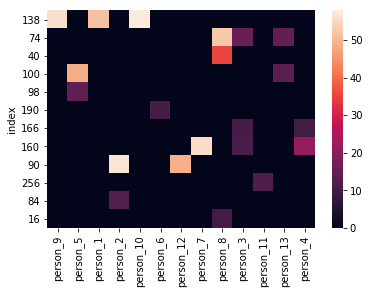

In [11]:
# Выделяем фичи, по которым больше всего пропусков для каждого пользователя.
# Может в дальнейшем вообще уберем их. Надо смотреть на вес конкретной фичи в результате.

# Пример, когда для пользователя по фиче пропущено больше 10%

sns.heatmap(missing_by_person(action_data, persons, percent=10))
plt.show()

In [12]:
# Удаляем пропуски в данных по заданному проценту пропусков
# percent - процент, выше которого удаляем
# num - количество пользователей, у которых процент по одной и той же фиче выше заданного

def drop_missing_values(df, persons, percent=50, num=2, inplace=False):
    missing = missing_by_person(df, persons, percent)
    fields_drop = missing[missing[missing > percent].count(axis=1) > num].index.values
    return df.drop(columns=fields_drop, inplace=inplace)

In [13]:
# Заполняем пропуски в данных заданным значением
# kind - определяет, каким образом заполняем пропуски

def fill_missing_values(df, kind='mean', inplace=False):
    func = {'mean': np.mean, 'median': np.median}
    return df.fillna(func[kind](df), inplace=inplace)

---
### Корреляция

In [60]:
# Посмотрим на корреляцию. Используем корреляцию Спирмена, так как в нашшем случае фичи - ранговые величины.

action_data_corr = action_data.corr(method='spearman')

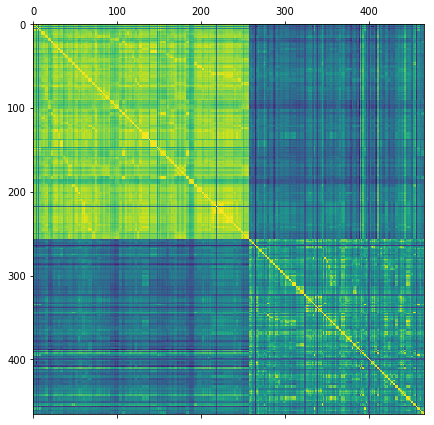

In [80]:
# Много кокоррелированных данных.

plt.figure(figsize=(7, 7))
plt.matshow(action_data_corr, fignum=1);

In [63]:
# Возможен случай, когда коэффициента корреляции нет. Это значит, что в данные поля скорее всего заполнены
# только одним одинаковым значением и их можно опустить при анализе. Проверим.

[i for i in action_data_corr if action_data_corr[i].isnull().drop_duplicates().values[0]]

[]

In [66]:
# Найдем поля, по которым коэффициент корреляции больше заданного значения.

def corr_by_column(df, corr_val, name='feature'):
    df_corr = df.corr(method='spearman')
    field_corr = []
    for i in df_corr:
        for j in df_corr.index[df_corr[i] > corr_val]:
            if i != j and j not in field_corr and i not in field_corr:
                field_corr.append(j)
    corr_table = pd.DataFrame(field_corr)
    corr_table = corr_table.rename(columns = {0 : name})
    return corr_table.reset_index()

In [67]:
# Объединяем в одну таблицу поля, по которым коэффициент корреляции больше заданного значения, для каждого пользователя
# Возвращаем DataFrame со списком фич по каждому пользователю

def corr_by_person(df, persons, corr_val):
    table = pd.DataFrame(data={'index': []})
    for person in persons:
        corr_table = corr_by_column(df[df['person_id'] == person], corr_val, person)
        if not corr_table.empty:
            table = table.merge(corr_table, on='index', how='outer')
    table.set_index('index', inplace=True)
    #table = table[table > percent].dropna(how='all').fillna(0)
    return table

In [68]:
# Удаляем поля, у которых коэффициент корреляции больше заданного значения.

def drop_corr_values(df, corr_val=0.9, inplace=False):
    return df.drop(corr_by_column(df, corr_val), axis=1, inplace=inplace)

---
### Значения, по которым не нужно оценок, и оценки, по которым нет исходных данных

In [69]:
# Посмотрим, есть ли в наборе оценок те, по которым нет данных для предсказания
# А также, есть ли данные, по которым не надо предсказывать

rating_dates = rating_data.groupby(['person_id']).agg({'date' : ['min', 'max']})
action_dates = action_data.groupby(['person_id']).agg({'date' : ['min', 'max']})

merge_dates = rating_dates.merge(action_dates, on='person_id', suffixes=('_rating', '_action'))
merge_dates.columns = ["_".join(x) for x in merge_dates.columns.ravel()]
merge_dates.reset_index(inplace=True)
merge_dates

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30
1,person_10,2017-06-09 08:40:30,2017-11-23 17:20:18,2017-06-01,2017-11-30
2,person_11,2017-06-02 15:13:35,2017-12-02 10:24:11,2017-06-01,2017-11-30
3,person_12,2017-06-02 09:40:41,2017-11-24 14:43:05,2017-06-01,2017-11-30
4,person_13,2017-06-02 20:14:19,2017-12-01 14:14:05,2017-06-01,2017-11-30
5,person_2,2017-06-02 15:56:41,2017-12-01 14:04:21,2017-06-01,2017-11-30
6,person_3,2017-06-02 18:49:14,2017-12-01 16:20:45,2017-06-01,2017-11-30
7,person_4,2017-06-09 15:04:22,2017-12-01 17:26:10,2017-06-01,2017-11-30
8,person_5,2017-06-02 15:14:58,2017-11-24 05:17:24,2017-06-01,2017-11-30
9,person_6,2017-06-09 12:19:35,2017-12-03 15:02:50,2017-06-01,2017-11-30


In [70]:
# Выбираем эти строки

rating_drop = merge_dates[merge_dates['date_rating_min'] < merge_dates['date_action_min']]
action_drop = merge_dates[merge_dates['date_rating_max'] < merge_dates['date_action_max']]

In [71]:
# По person_1 есть "лишняя" оценка до сбора показаний поведения

rating_drop

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30


In [72]:
# По person_1, person_10, person_12, person_5, person_7, person_8, person_9 
# есть "лишние" записи действий пользователей (по ним не надо строить предсказание, либо оценки нет)

action_drop

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30
1,person_10,2017-06-09 08:40:30,2017-11-23 17:20:18,2017-06-01,2017-11-30
3,person_12,2017-06-02 09:40:41,2017-11-24 14:43:05,2017-06-01,2017-11-30
8,person_5,2017-06-02 15:14:58,2017-11-24 05:17:24,2017-06-01,2017-11-30
10,person_7,2017-06-02 16:51:14,2017-11-24 09:20:03,2017-06-01,2017-11-30
11,person_8,2017-06-02 16:54:11,2017-11-24 18:57:56,2017-06-01,2017-11-30
12,person_9,2017-06-02 10:03:36,2017-11-24 04:21:09,2017-06-01,2017-11-30


In [74]:
# Удаляем запись person_1 с "лишней" оценкой поведения

def drop_extra_rating(df, df_drop, inplace=False):
    for i, row in df_drop.iterrows():
        index = df[(df['person_id'] == row['person_id']) & (df['date'] < row['date_action_min'])].index
        df.drop(index=index, inplace=inplace)
    return df

In [75]:
# Удаляем записи person_1, person_10, person_12, person_5, person_7, person_8, person_9
# с "лишними" записями действий пользователей (по ним не надо строить предсказание, либо оценки нет)

def drop_extra_action(df, df_drop, inplace=False):
    for i, row in df_drop.iterrows():
        index = df[(df['person_id'] == row['person_id']) & (df['date'] > row['date_rating_max'])].index
        df.drop(index=index, inplace=inplace)
    return df

---
### Нормировка

In [89]:
from sklearn.preprocessing import StandardScaler

def scaler(df, feature_labels):
    scaler_data = df[feature_labels]
    scaler = StandardScaler()
    scaler_data = pd.DataFrame(scaler.fit_transform(scaler_data), columns=feature_labels)
    scaler_data['person_id'] = df['person_id']
    scaler_data['date'] = df['date']
    return scaler_data

---
### Запись результатов в файл

In [88]:
def answer_to_file(predicted, Ids, file_name):
    df_answer = pd.DataFrame(data=Ids, columns=['Id'])
    df_answer['Prediction1'] = predicted
    df_answer.to_csv(file_name, index=False)

---
### Обработка и подготовка данных

In [104]:
# Обрабоатывам данные заданной функцией
# kind - определяет, какой функцией

def apply_func_data(df, kind='mean'):
    func = {'mean': np.mean, 'median': np.median}
    return df.apply(func[kind])

In [ ]:
# Здесь готовим данные для выставленной оценки с учетом поведения за выбранный интервал для каждого поля в таблице оценок

def func_for_rating(rating, action, labels, delta='7 days', kind='mean'):
    
    df = rating[]
    
    for rating in df_rating:
        range_data = get_range_data(df_action, person)

In [108]:
df = rating_data[rating_data['person_id'].isin(persons_known)]

In [131]:
df = pd.DataFrame(columns=feature_labels)

In [136]:
vals = np.arange(0, len(feature_labels))

In [39]:
# Формируем матрицу признаков

In [ ]:
# 1. Копируем из фрейма оценок



---
## Предсказываем оценки

### Вариант 0. Предсказывать медианное значение по исходной выборке

In [96]:
# выделим выборки целевых значений

y_true = rating_data[rating_data['person_id'].isin(persons_known)]
y_target = rating_data[rating_data['person_id'].isin(persons_unknown)]

y_pred = y_true['Prediction1'].quantile(q=0.50) * np.ones(y_target.shape[0])
answer_to_file(y_pred, y_target['Id'].values, 'baseline.csv')

---
### Вариант 1.

---

In [11]:
# разобьем выборку по временным интервалам между выставлениями оценок для каждого пользователя

# интервалы времени между оценками по пользователю
# возвращаем даты начала и окончания диапазона + Id записи

def get_ranges(data, person):
    ranges = []
    df = data[data['person_id'] == person]
    for idx in range(df.shape[0]):
        start_date = end_date if (idx > 0) else (df.iloc[idx]['date'] - pd.to_timedelta('7 days'))
        end_date = df.iloc[idx]['date']
        ranges.append([start_date, end_date, df.iloc[idx]['Id']])
    return ranges

In [12]:
# данные фич по пользователю за заданный интервал времени
# dates[0] - start date
# dates[1] - end date

def get_range_data(data, person, dates):
    df = data[data['person_id'] == person]
    mask = (df['date'] > dates[0]) & (df['date'] < dates[1])
    return df[mask]

In [229]:
# Усредняем каждую фичу за интервал между выставлениями оценок пользователем

def data_mean(persons, targets, data):
    X = []
    Ids = []
    for person in persons:
        ranges = get_ranges(targets, person)
        for ra in ranges:
            da = get_range_data(data, person, ra)              
            xa = da.mean() if not da.empty else 0
            X.append(xa)
    return [X, Ids]

In [1]:
# взвешиваем каждую фичу за интервал между выставлениями оценок пользователем

def data_weight(persons, targets, data):
    pass

---

In [230]:
# Вариант 1. Усредняем каждую фичу за интервал между выставлениями оценок пользователем. Дальше - используем линейную регрессию

# Добавляем вектор из единиц для коэффициента w0 линейной регрессии.
df_data_scaler['bias'] = 1

X_true = data_mean(known_persons, df_targets, df_data_scaler)
X_target = data_mean(unknown_persons, df_targets, df_data_scaler)

In [226]:
# удаляем оценки, по которым нет предшествующих данных

#y_true = y_true.drop(y_true[y_true['Id'].isin(Ids_true)].index)
#y_target = y_target.drop(y_target[y_target['Id'].isin(Ids_target)].index)

In [241]:
# обнуляем пустые значения фич

X_true = np.array(X_true)
X_true[np.isnan(X_true)] = 0

X_target = np.array(X_target)
X_target[np.isnan(X_target)] = 0

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_true, y_true['Prediction1'].values, test_size=0.2, random_state=42)

---
Linear Regression

In [175]:
from sklearn.linear_model import LinearRegression

In [192]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [193]:
linear_reg.score(X_test, y_test)

-1.4209208003885672

In [194]:
y_pred = linear_reg.predict(X_target)

In [195]:
y_pred.round()

array([ 4.,  4.,  4.,  4.,  3.,  6.,  6.,  3.,  6.,  6.,  4.,  7.,  6.,
        6.,  5.,  9., 10., 10.,  5.,  5.,  4.,  4.,  4.,  4.,  5.,  4.,
        4.,  4.,  3.,  6.,  6.,  3.,  6.,  6.,  4.,  7.,  6.,  6.,  5.,
        9., 10., 10.,  5.,  5.,  4.,  4.,  4.,  4.,  5.,  3.,  5.,  4.,
        4.,  2.,  4.,  1.,  3.,  3.,  6.,  3.,  4.,  4.,  2.,  3.,  4.,
        1.,  6.,  2.,  4.,  2.,  2.,  1.,  3.,  3.,  2.,  2.,  5.,  4.,
        4.,  2.,  4.,  1.,  3.,  3.,  6.,  3.,  4.,  4.,  2.,  3.,  4.,
        1.,  6.,  2.,  4.,  2.,  2.,  1.,  3.,  3.,  2.,  2., 10.,  2.,
        4.,  2.,  3.,  4.,  4.,  7.,  5.,  3.,  0.,  4.,  1.,  2.,  3.,
        2.,  5.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  4.,  4.,  2.,  4.,
        2.,  3.,  4.,  4.,  7.,  5.,  3.,  0.,  4.,  1.,  2.,  3.,  2.,
        5.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  4.,  4.])

In [74]:
answer_to_file(y_pred, y_target['Id'].values, 'linear_regression.csv')

---
Random Forest Regressor

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [189]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [197]:
forest_reg.score(X_test, y_test)

0.09767736821244544

---
Gradient boosting

In [198]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
boost_reg = ensemble.GradientBoostingRegressor()

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(logistic_reg, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

In [199]:
boost_reg = ensemble.GradientBoostingRegressor()
boost_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [200]:
boost_reg.score(X_test, y_test)

0.042049635747543834

---
Logistic Regression

In [215]:
from sklearn.linear_model import LogisticRegression

In [216]:
logistic_reg = LogisticRegression(solver='saga', multi_class='multinomial')

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(logistic_reg, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1, 2, 3, 4]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [217]:
search.best_params_

{'C': 1, 'penalty': 'l2'}

In [205]:
accuracy_score(y_train, search.best_estimator_.predict(X_train))

0.9170731707317074

In [218]:
logistic_reg = LogisticRegression(C=1, penalty='l2', solver='saga', multi_class='multinomial')
logistic_reg.fit(X_train, y_train)
pred_prob = logistic_reg.predict_proba(X_test)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [219]:
y_pred = logistic_reg.predict(X_target)

In [220]:
answer_to_file(y_pred, y_target['Id'].values, 'logistic_regression.csv')

In [5]:
# есть подозрение, что нужно пронормировать данные, но это не точно

---

In [3]:
# делаем one hot encoding, не знаю, насколько это здесь нужно

In [7]:
for person in persons:
    df_data[person] = pd.Series(data=(df_data['person_id'] == person).astype('float'), index=df_data.index)

features

In [8]:
X_labels = np.delete(df_data.columns.values, [0, 1])

In [9]:
df_X = df_data[df_data['person_id'].isin(known_persons)]
X = df_X[X_labels].values
X[np.isnan(X)] = 0

In [10]:
df_X_target = df_data[df_data['person_id'].isin(target_persons)]
X_target = df_X_target[X_labels].values
X_target[np.isnan(X_target)] = 0

answers

In [11]:
def get_prediction(person, date):
    
    df = df_predictions[df_predictions['person_id'] == person]
    
    for idx in range(df.shape[0]):
        start_date = end_date if (idx > 0) else (df.iloc[idx]['date'] - pd.to_timedelta('7 days'))
        end_date = df.iloc[idx]['date']
        mask = (date > start_date) & (date <= end_date)
        if mask:
            return df.iloc[idx]['Prediction1'] 
    return 0

In [12]:
y = np.zeros(X.shape[0])
y_target = np.zeros(X_target.shape[0])

In [13]:
for idx in range(X.shape[0]):
    y[idx] = get_prediction(df_X.iloc[idx]['person_id'], df_X.iloc[idx]['date'])
    #print('person = {}, date = {}, val = {}'.format(df_X.iloc[idx]['person_id'], df_X.iloc[idx]['date'], y[idx]))

---

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [16]:
clf = LogisticRegression(solver='saga', max_iter=200, multi_class='multinomial')

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1, 2, 3, 4]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
search.best_params_

{'C': 3, 'penalty': 'l2'}

In [18]:
accuracy_score(y_train, search.best_estimator_.predict(X_train))

0.5635245901639344

In [24]:
optimal_clf = LogisticRegression(C=3, penalty='l2', solver='saga', max_iter=200, multi_class='multinomial')
optimal_clf.fit(X_train, y_train)
pred_prob = optimal_clf.predict_proba(X_test)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [25]:
pred_prob

array([[1.82303191e-03, 3.93654722e-02, 5.55126205e-02, 8.20919688e-01,
        8.01838760e-02, 2.19531131e-03],
       [4.78618194e-03, 8.15590737e-02, 3.25747731e-02, 2.02872916e-02,
        7.94969185e-01, 6.58234950e-02],
       [2.73111315e-04, 8.71674652e-03, 7.01162711e-01, 4.12115116e-02,
        2.46791657e-01, 1.84426270e-03],
       ...,
       [1.28463536e-01, 2.54449341e-02, 1.27131907e-01, 6.32734254e-01,
        5.36400920e-02, 3.25852765e-02],
       [4.08065181e-03, 1.30562908e-02, 6.02840759e-01, 2.14474663e-01,
        1.64015926e-01, 1.53170940e-03],
       [3.79482808e-02, 3.37482089e-01, 1.89276665e-01, 2.04731216e-01,
        1.96347207e-01, 3.42145424e-02]])

---

K-Neighbors Classifier

In [20]:
clf = KNeighborsClassifier()

param_grid = {'weights': ['uniform', 'distance'], 'n_neighbors': np.arange(10, 20), 'metric': ['manhattan', 'euclidean']}

search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'metric': ['manhattan', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [21]:
search.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

In [22]:
optimal_clf = KNeighborsClassifier(n_neighbors=13, metric='manhattan', weights='distance')
optimal_clf.fit(X_train, y_train)
pred_prob = optimal_clf.predict_proba(X_test)

In [23]:
pred_prob

array([[0.        , 0.        , 0.        , 0.92900969, 0.07099031,
        0.        ],
       [0.07118421, 0.0733502 , 0.        , 0.        , 0.71389433,
        0.14157125],
       [0.        , 0.        , 0.76070257, 0.15971696, 0.07958047,
        0.        ],
       ...,
       [0.15659164, 0.07815148, 0.15334241, 0.53662788, 0.07528658,
        0.        ],
       [0.        , 0.        , 0.46211895, 0.30677005, 0.23111101,
        0.        ],
       [0.159373  , 0.07960921, 0.15239564, 0.3808546 , 0.07592782,
        0.15183974]])

---